In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np

from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

In [2]:
class LaneDetectionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.image_paths = sorted(glob.glob(os.path.join(root_dir, '*.png')))

        # Print the number of loaded images
        print(f"Number of images: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [3]:
root_dir = "/kaggle/input/lane-detection-for-carla-driving-simulator/train"

transform = pth_transforms.Compose([
    pth_transforms.Resize((256, 256)),
    pth_transforms.ToTensor(),
])

dataset = LaneDetectionDataset(root_dir=root_dir, transform=transform)

loader = DataLoader(dataset, batch_size=1, shuffle=False)

Number of images: 3075


In [4]:
sam_checkpoint = '/kaggle/input/segment-anything/pytorch/vit-l/1/model.pth'
model_type = "vit_l" #
device = "cpu" #cpu,cuda

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)
predictor = SamPredictor(sam)

In [5]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

(256, 256, 3)


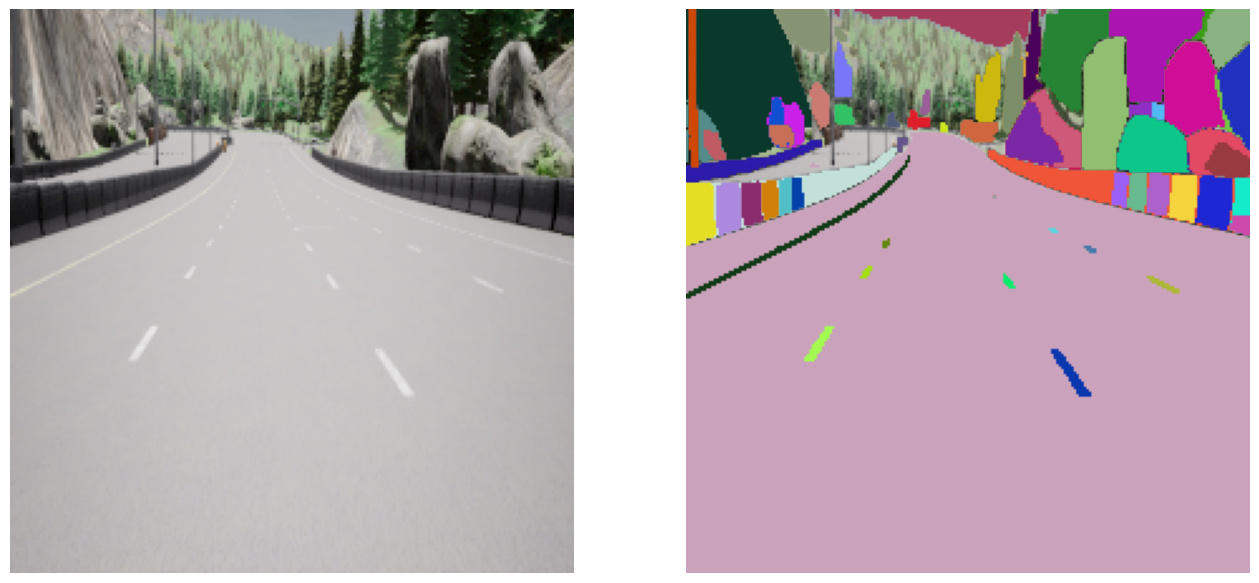

In [22]:
# Define detect_lanes function

def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

num_images = 10
random_indices = random.sample(range(len(dataset)), num_images)
image_tensor= dataset[0]
image_path = "/kaggle/input/lane-detection-for-carla-driving-simulator/train/Town04_Clear_Noon_09_09_2020_14_57_22_frame_1001.png"
image_information = cv2.imread(image_path)
image = cv2.resize(image_information, (224,224))
masks = mask_generator1.generate(image)


image_np = image_tensor.numpy()
# Reshape the image data to a valid shape
image_data = np.moveaxis(image_np, 0, -1)  # Move the channels axis to the last position
print(image_data.shape)  # Output: (256, 256, 3)
# Plot the original image and the mask


# Plot the original image and the mask
fig, axs = plt.subplots(1, 2, figsize=(16, 16))
axs[0].imshow(image)
axs[1].imshow(image)
show_anns(masks, axs[1])
axs[0].axis('off')
axs[1].axis('off')
plt.show()
